# OSM MatPlotLib Visualizations

Data Exploration: matplotlib

In [230]:
# imports 

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2 # matplotlib's venn diagram
import folium # map visuals
import numpy as np

In [231]:
slofood_parquet = pd.read_parquet("slofood_cleaned.parquet")
davisfood_parquet = pd.read_parquet("davisfood_cleaned.parquet")
athensfood_parquet = pd.read_parquet("athensfood_cleaned.parquet")

First, just for context, I want to look at how active users are for each of the towns. Like r/place pixels, users can place a location down and edit the data so it contains information on things like what kind of place it is, and from there any specific characteristics. So, there includes a timestamp for when this location was placed down.

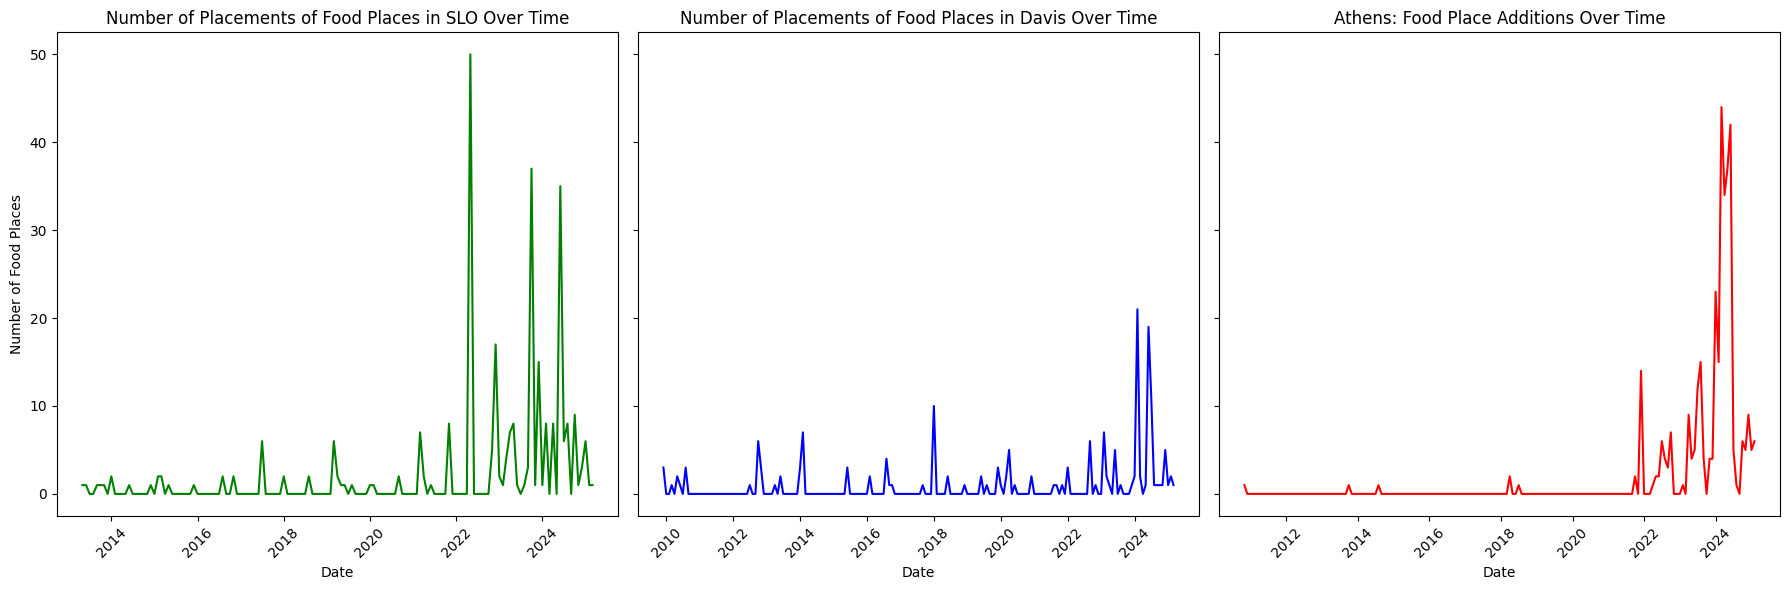

In [232]:
# resample by month
slofood_bymonth = slofood_parquet.resample('ME', on='timestamp').size()
davisfood_bymonth = davisfood_parquet.resample('ME', on='timestamp').size()
athensfood_bymonth = athensfood_parquet.resample('ME', on='timestamp').size()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot SLO data
axes[0].plot(slofood_bymonth.index, slofood_bymonth.values, color='green')
axes[0].set_title('Number of Placements of Food Places in SLO Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Food Places')
axes[0].tick_params(axis='x', rotation=45)

# Plot Davis data
axes[1].plot(davisfood_bymonth.index, davisfood_bymonth.values, color='blue')
axes[1].set_title('Number of Placements of Food Places in Davis Over Time')
axes[1].set_xlabel('Date')
axes[1].tick_params(axis='x', rotation=45)

# Plot Athens data
axes[2].plot(athensfood_bymonth.index, athensfood_bymonth.values, color='red')
axes[2].set_title('Athens: Food Place Additions Over Time')
axes[2].set_xlabel('Date')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Now, I want to look at all the tags from the dataset.

## Cuisines

According to the openstreetmap wiki page, `cuisine` is used to describe the type of food served at a place. The most common values can range from describing
- ethnic, national, regional, or cultural origin of food served at a place
- specific food items a place is known for
- style of food served at a place or the type of place it is

(https://wiki.openstreetmap.org/wiki/Key:cuisine)

Cuisine distribution seems like a good start. How do the cuisines compare between towns? What is more prominent in SLO? What about Davis or Athens?

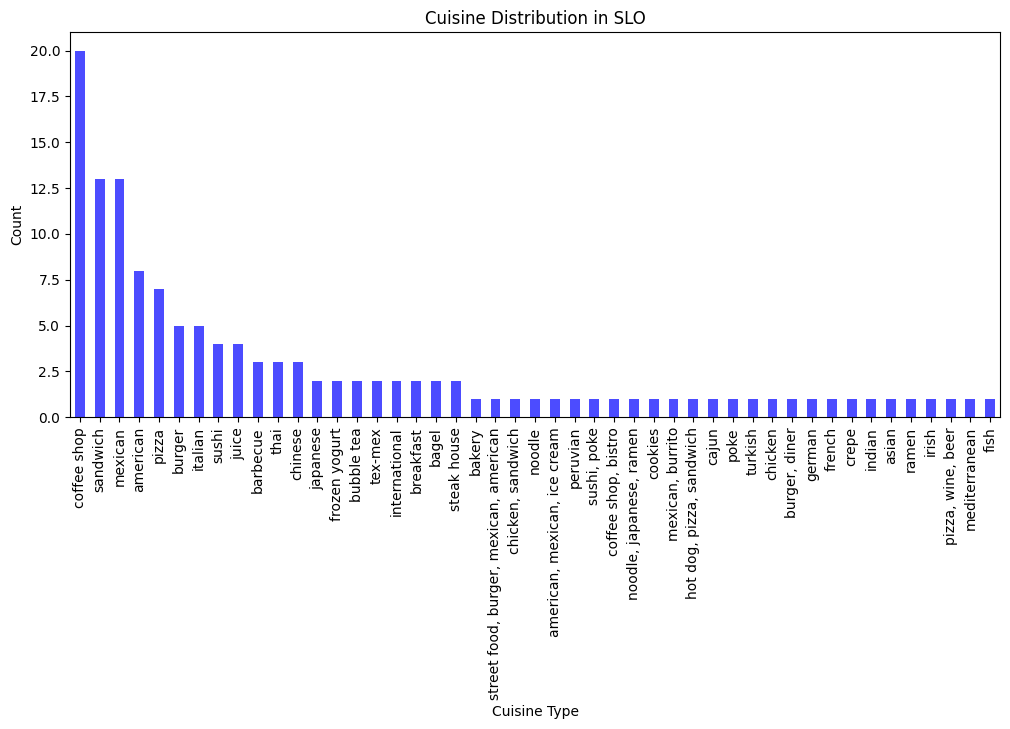

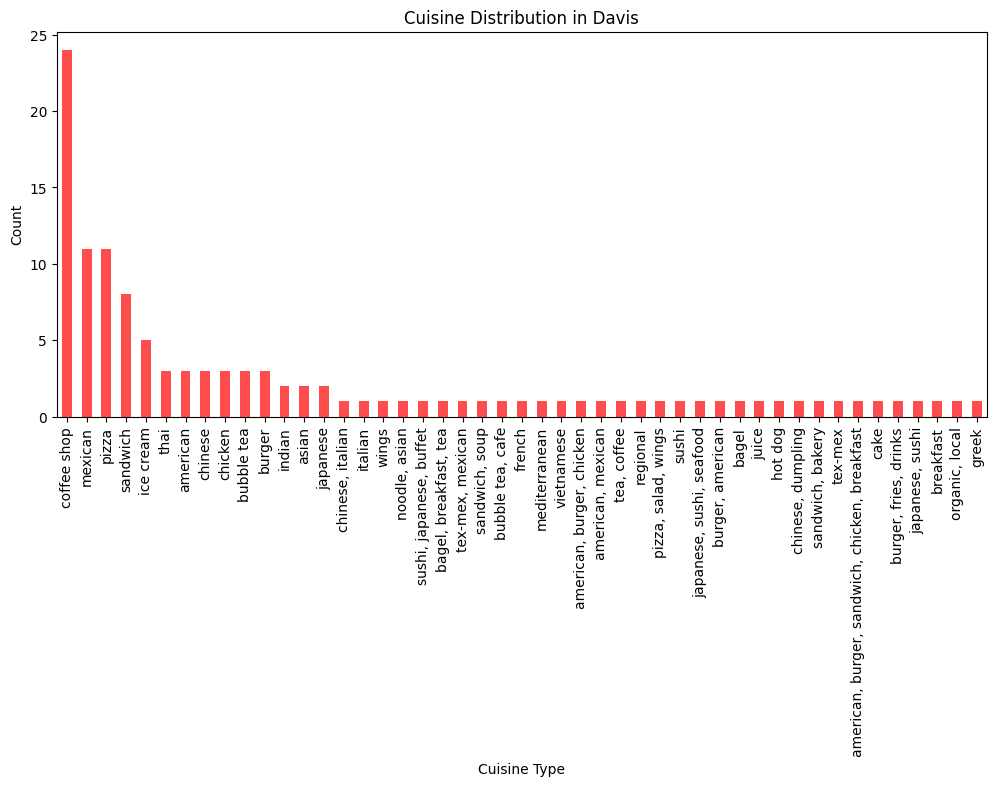

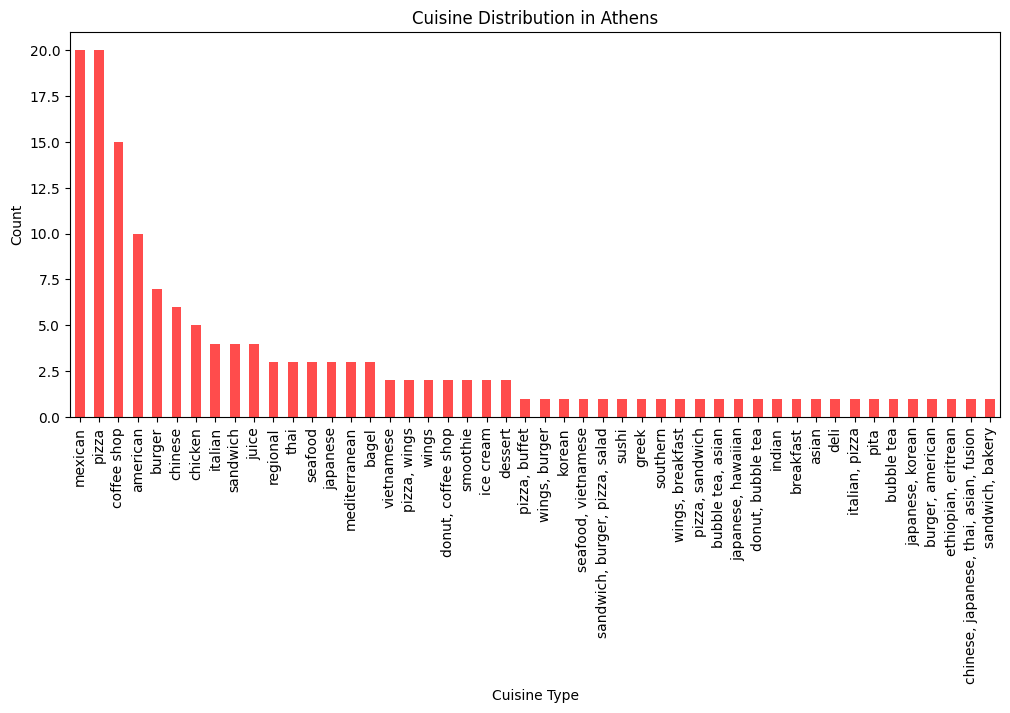

In [233]:
# cuisine distributions

# count occurrences of each cuisine type
slo_cuisine_counts = slofood_parquet['cuisine'].value_counts()
davis_cuisine_counts = davisfood_parquet['cuisine'].value_counts()
athens_cuisine_counts = athensfood_parquet['cuisine'].value_counts()

# plot slo cuisine distrib
plt.figure(figsize=(12, 5))
slo_cuisine_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel("Cuisine Type")
plt.ylabel("Count")
plt.title("Cuisine Distribution in SLO")
plt.xticks(rotation=90)
plt.show()

# plot davis cuisine distribution
plt.figure(figsize=(12, 5))
davis_cuisine_counts.plot(kind='bar', color='red', alpha=0.7)
plt.xlabel("Cuisine Type")
plt.ylabel("Count")
plt.title("Cuisine Distribution in Davis")
plt.xticks(rotation=90)
plt.show()

# plot athens cuisine distribution
plt.figure(figsize=(12, 5))
athens_cuisine_counts.plot(kind='bar', color='red', alpha=0.7)
plt.xlabel("Cuisine Type")
plt.ylabel("Count")
plt.title("Cuisine Distribution in Athens")
plt.xticks(rotation=90)
plt.show()

Since there's so many cuisines, and cuisine types where they repeat (different combinations like `chinese;american` instead of just `chinese` and `american`), I want to look at which cuisines they do have in common.

Common Cuisines:
{'bagel', 'thai', 'sushi', 'pizza', 'french', 'chinese', 'bubble tea', 'chicken', 'italian', 'american', 'breakfast', 'tex-mex', 'mediterranean', 'indian', 'juice', 'burger', 'sandwich', 'mexican', 'japanese', 'coffee shop', 'asian'}

SLO-only Cuisines:
{'barbecue', 'frozen yogurt', 'burger, diner', 'irish', 'turkish', 'poke', 'noodle, japanese, ramen', 'cookies', 'steak house', 'coffee shop, bistro', 'fish', 'german', 'ramen', 'sushi, poke', 'noodle', 'bakery', 'chicken, sandwich', 'street food, burger, mexican, american', 'american, mexican, ice cream', 'peruvian', 'mexican, burrito', 'crepe', 'international', 'pizza, wine, beer', 'hot dog, pizza, sandwich', 'cajun'}

Davis-only Cuisines:
{'greek', 'noodle, asian', 'wings', 'tea, coffee', 'american, mexican', 'sandwich, bakery', 'american, burger, sandwich, chicken, breakfast', 'sandwich, soup', 'organic, local', 'pizza, salad, wings', 'bubble tea, cafe', 'japanese, sushi', 'cake', 'bagel, breakfast, tea', 'hot dog',

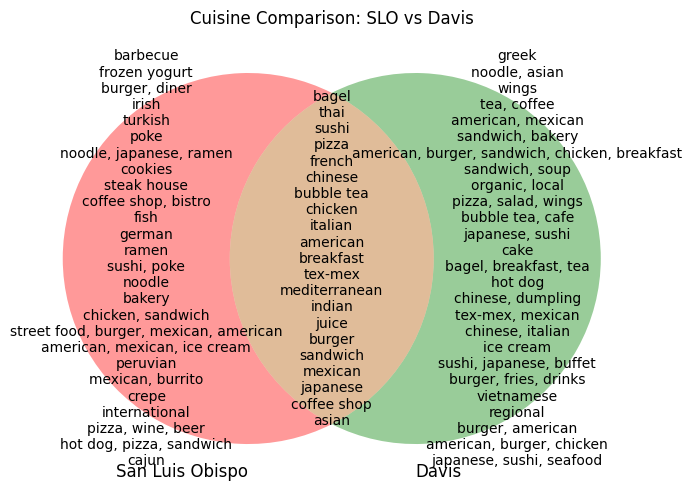

In [234]:
# compare cuisine types

# unique cuisines
slo_cuisines = set(slofood_parquet['cuisine'].dropna().unique())
davis_cuisines = set(davisfood_parquet['cuisine'].dropna().unique())

# find common and unique cuisines
common_cuisines = slo_cuisines & davis_cuisines
slo_unique = slo_cuisines - davis_cuisines
davis_unique = davis_cuisines - slo_cuisines

# print
print("Common Cuisines:")
print(common_cuisines)
print("\nSLO-only Cuisines:")
print(slo_unique)
print("\nDavis-only Cuisines:")
print(davis_unique)

print("")

# print summary
print(f"Common cuisines: {len(common_cuisines)} types")
print(f"SLO-only cuisines: {len(slo_unique)} types")
print(f"Davis-only cuisines: {len(davis_unique)} types")

# venn diagram?
plt.figure(figsize=(8, 8))
venn = venn2([slo_cuisines, davis_cuisines], ('San Luis Obispo', 'Davis'))

# Label each region with the actual cuisine types
venn.get_label_by_id('10').set_text('\n'.join(slo_unique))   # SLO-only cuisines
venn.get_label_by_id('01').set_text('\n'.join(davis_unique)) # Davis-only cuisines
venn.get_label_by_id('11').set_text('\n'.join(common_cuisines)) # Common cuisines

plt.title("Cuisine Comparison: SLO vs Davis")
plt.show()


A venn diagram seems like it would be interesting to show comparisons. However, it can be hard to look at.

Let's try a bar chart for just common cuisines.

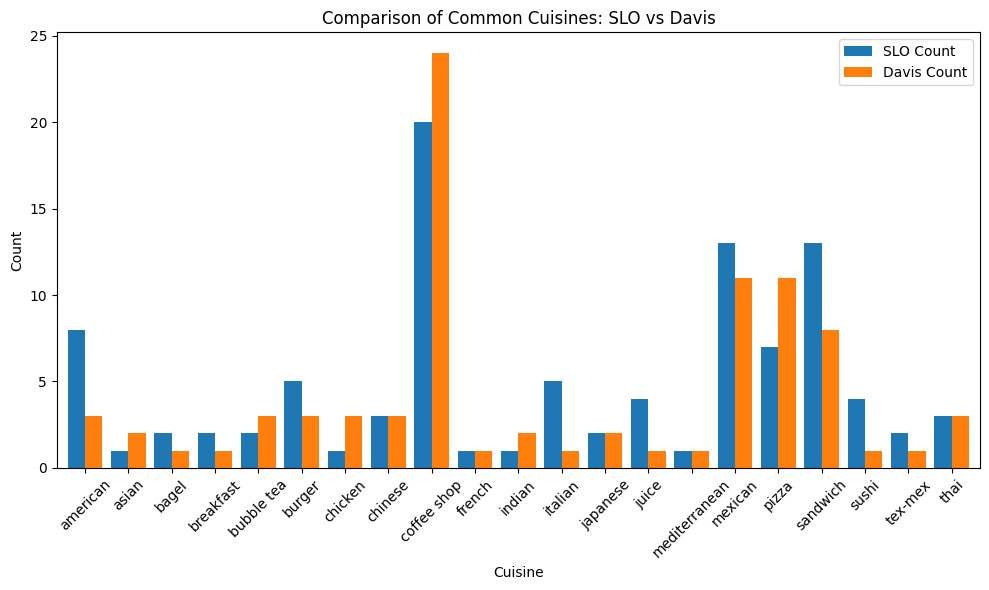

In [235]:
# count common cuisine in slo & davis
slo_cuisine_count = slofood_parquet[slofood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()
davis_cuisine_count = davisfood_parquet[davisfood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()

comparison_df = pd.DataFrame({
    'SLO Count': slo_cuisine_count,
    'Davis Count': davis_cuisine_count
}).fillna(0)

comparison_df

# bar chart
comparison_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title("Comparison of Common Cuisines: SLO vs Davis")
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

^^ 
- more American, Italian, Juice & Sandwich "cuisines" in SLO
- more coffee shops & pizza in Davis
- in general, lots of coffee shops

Let's look at places with those cuisines in SLO
- seems to have lots of the same restaurant
- Davis just has less (not necessarily that SLO has lots of something)

In [236]:
slofood_parquet[slofood_parquet['cuisine']=='american']
slofood_parquet[slofood_parquet['cuisine']=='italian']
slofood_parquet[slofood_parquet['cuisine']=='juice'] # 3 Jamba's & Shake Smart
slofood_parquet[slofood_parquet['cuisine']=='sandwich'] # lots of Subways

,id,timestamp,lat,lon,amenity,brand,cuisine,name,shop
0,573859956,2024-03-19 13:03:23+00:00,35.249339,-120.642032,fast food,Jersey Mike's Subs,sandwich,Jersey Mike's Subs,fast food
13,932573584,2023-02-13 17:46:08+00:00,35.276715,-120.656643,restaurant,None,sandwich,Gus's Grocery,restaurant
26,2004789694,2024-05-19 11:55:47+00:00,35.269265,-120.670827,fast food,Subway,sandwich,Subway,fast food
38,2261957364,2023-11-18 15:20:40+00:00,35.293894,-120.671971,restaurant,None,sandwich,Capriottti's Sandwich Shop,restaurant
54,2396485350,2015-02-23 21:40:54+00:00,35.293632,-120.668885,fast food,None,sandwich,Kona's Deli,fast food
77,2456192003,2024-03-10 17:11:34+00:00,35.279957,-120.661591,fast food,None,sandwich,None,fast food
107,3639544132,2024-05-19 11:55:47+00:00,35.300877,-120.663294,fast food,Subway,sandwich,Subway,fast food
112,3785441611,2024-05-19 11:55:47+00:00,35.259771,-120.648437,fast food,Subway,sandwich,Subway,fast food
118,4049015939,2024-01-16 00:53:57+00:00,35.280074,-120.663170,fast food,Which Wich?,sandwich,Which Wich?,fast food
138,4915321268,2024-09-20 19:57:50+00:00,35.283852,-120.658204,restaurant,None,sandwich,Hoagies,restaurant


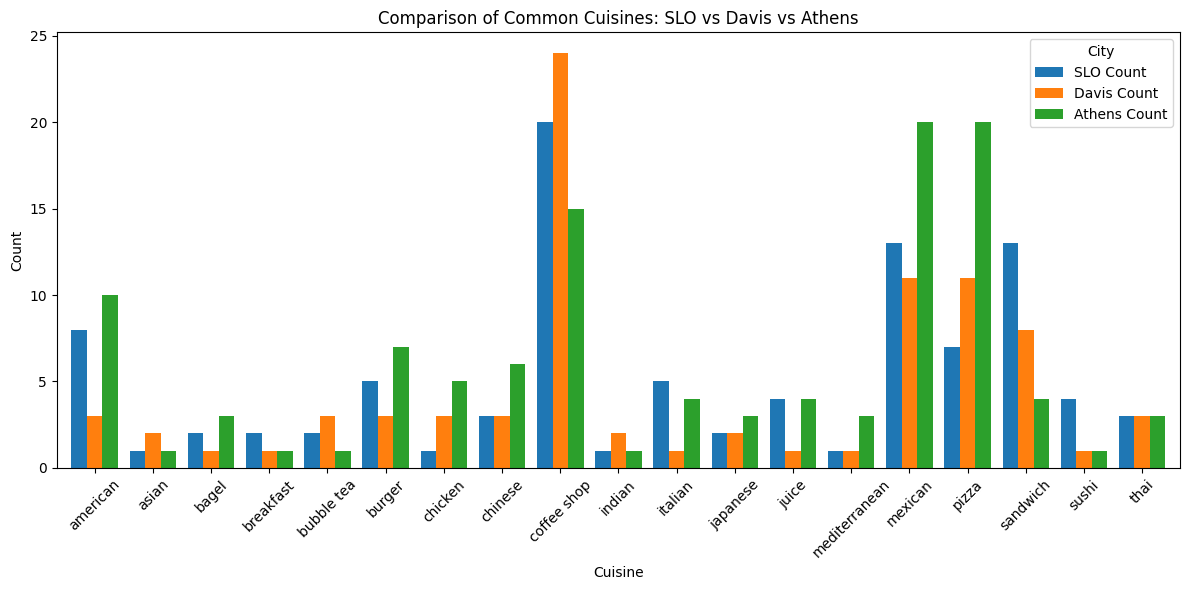

In [237]:
common_cuisines = set(slofood_parquet['cuisine']).intersection(davisfood_parquet['cuisine'], athensfood_parquet['cuisine']) 

slo_cuisine_count = slofood_parquet[slofood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()
davis_cuisine_count = davisfood_parquet[davisfood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()
athens_cuisine_count = athensfood_parquet[athensfood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()

comparison_df = pd.DataFrame({
    'SLO Count': slo_cuisine_count,
    'Davis Count': davis_cuisine_count,
    'Athens Count': athens_cuisine_count
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("Comparison of Common Cuisines: SLO vs Davis vs Athens")
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title="City")
plt.tight_layout()
plt.show()

In [238]:
# cool interactive pie chart?

import plotly.io as pio
pio.renderers.default = 'browser'


import plotly.express as px
cuisine_counts = slofood_parquet['cuisine'].value_counts().reset_index()
cuisine_counts.columns = ['Cuisine', 'Count']
fig = px.sunburst(cuisine_counts, path=['Cuisine'], values='Count', title="Cuisine Distribution in SLO")
fig.show()

## Big Brands

According to the openstreetmap wiki page, `brand` is used to describe either the principal brand of goods or services that are sold in an outlet, or represents a common identity for individually owned-and-operated stores.

In my case, since I'm looking at food locations, this would include big branded, chain restuarants or convience stores. 

(https://wiki.openstreetmap.org/wiki/Key:brand)

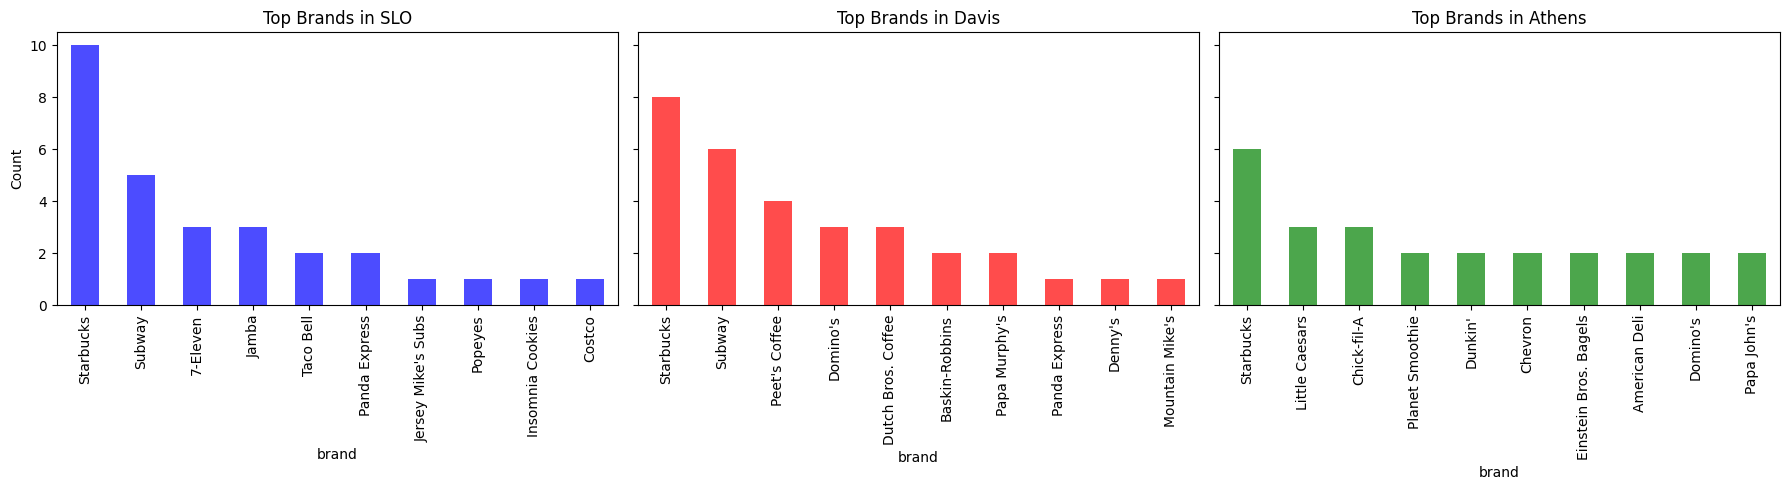

In [239]:
slo_brand_counts = slofood_parquet['brand'].value_counts().head(10)
davis_brand_counts = davisfood_parquet['brand'].value_counts().head(10)
athens_brand_counts = athensfood_parquet['brand'].value_counts().head(10) # top 10

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot SLO brands
slo_brand_counts.plot(kind='bar', ax=axes[0], color='blue', alpha=0.7)
axes[0].set_title("Top Brands in SLO")
axes[0].set_ylabel("Count")

# Plot Davis brands
davis_brand_counts.plot(kind='bar', ax=axes[1], color='red', alpha=0.7)
axes[1].set_title("Top Brands in Davis")

# Plot Athens brands
athens_brand_counts.plot(kind='bar', ax=axes[2], color='green', alpha=0.7)
axes[2].set_title("Top Brands in Athens")

plt.tight_layout()
plt.show()


For brands, 

- all towns have Starbucks which is the dominant brand, however SLO has the most of them.  
- SLO and Davis have more similarity among the top brands compared to Athens (Subway, Panda Express)
- lots of pizza for Athen's 

## Amenities

According to the openstreetmap wiki page, `amenity` is the top-level tag describing useful and important facilities for visitors and residents, such as toilets, telephones, banks, pharmacies, prisons and schools.

In my case, I extracted 10 food-related amenities (reference parsing.ipynb for which ones).

(https://wiki.openstreetmap.org/wiki/Key:amenity)

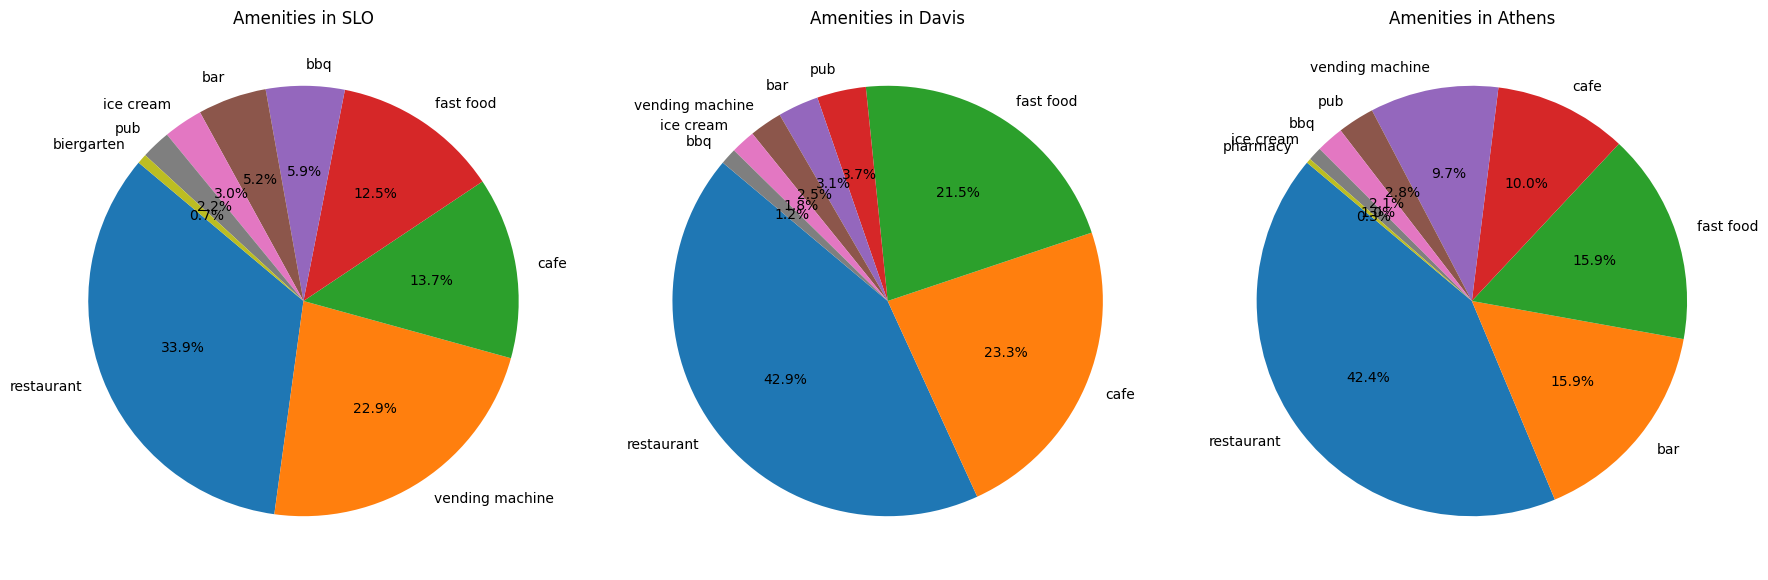

In [240]:
slo_amenity_counts = slofood_parquet['amenity'].value_counts()
davis_amenity_counts = davisfood_parquet['amenity'].value_counts()
athens_amenity_counts = athensfood_parquet['amenity'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot SLO amenities
axes[0].pie(slo_amenity_counts, labels=slo_amenity_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Amenities in SLO")

# Plot Davis amenities
axes[1].pie(davis_amenity_counts, labels=davis_amenity_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Amenities in Davis")

# Plot Athens amenities
axes[2].pie(athens_amenity_counts, labels=athens_amenity_counts.index, autopct='%1.1f%%', startangle=140)
axes[2].set_title("Amenities in Athens")

plt.tight_layout()
plt.show()

For some reason, vending machines are SLO's second top amenity?

In [241]:
# look at vending machines in SLO

vending_machines = slofood_parquet[slofood_parquet['amenity'] == 'vending machine'] # filter thru vending machines only

slo_vending = folium.Map(location=[35.2828, -120.6596], zoom_start=13)

for _, row in vending_machines.iterrows():
    lat = row['lat']
    lon = row['lon']
    
    folium.Marker(
        location=[lat, lon],
        # popup=f"Vending Machine\n{name}",  # Add more info in the popup if needed
        icon=folium.Icon(color='blue', icon='info-sign')  # Customize marker appearance
    ).add_to(slo_vending)

slo_vending

In [242]:
len(vending_machines)

62

SLO has 62 vending machines, with them densely on campus or on Higuera and Marsh Street.

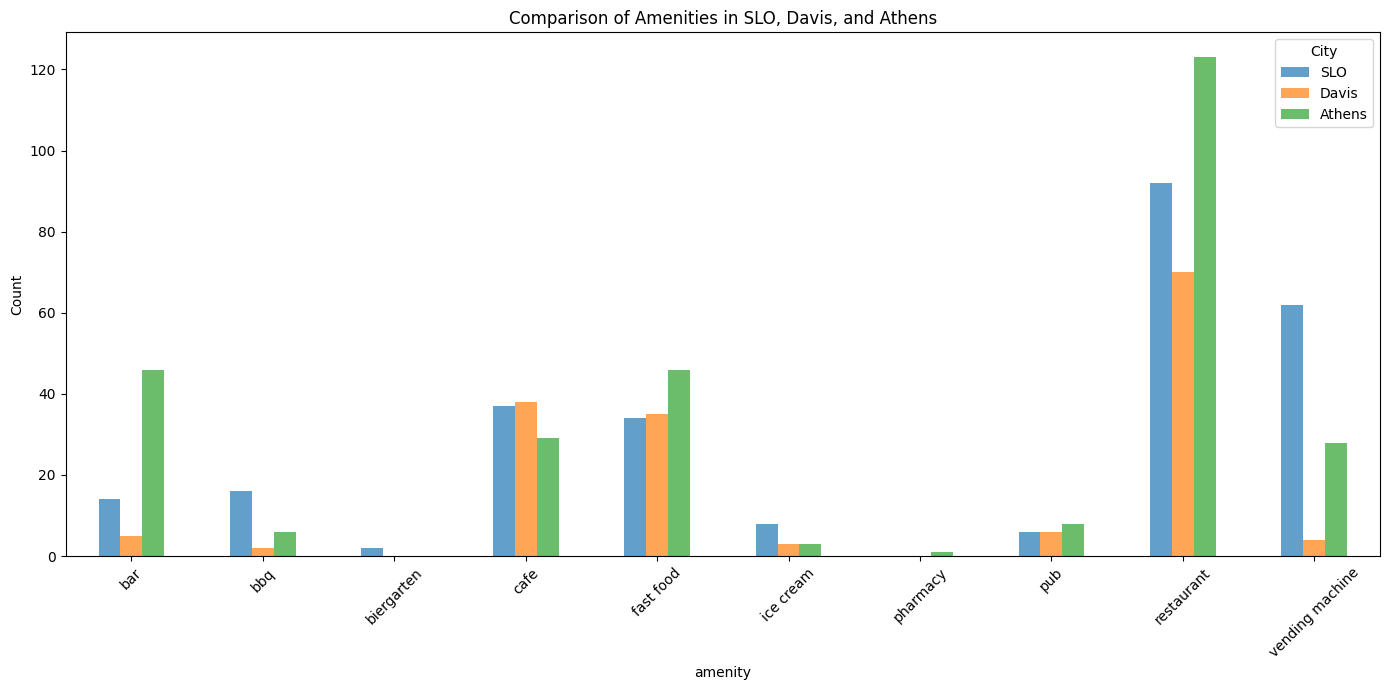

In [243]:
amenity_compare = pd.DataFrame({
    'SLO': slofood_parquet['amenity'].value_counts(),
    'Davis': davisfood_parquet['amenity'].value_counts(),
    'Athens': athensfood_parquet['amenity'].value_counts()
})

amenity_compare.fillna(0, inplace=True)

amenity_compare.plot(kind='bar', figsize=(14, 7), alpha=0.7)
plt.ylabel("Count")
plt.title("Comparison of Amenities in SLO, Davis, and Athens")
plt.xticks(rotation=45)
plt.legend(title="City")
plt.tight_layout()
plt.show()

From the comparison of amenities between the towns,

- Athens has a lot of bars (almost 50)
- more ice cream shops in SLO

## Shop

According to the openstreetmap wiki page, `shop` is used to mark the location of a shop, or a place selling retail products or offering services. I have focused on food and beverage related shops. The data does not only include restaurants, but also stores to buy food like supermarkets, and specific food/beverage items.

(https://wiki.openstreetmap.org/wiki/Key:shop)

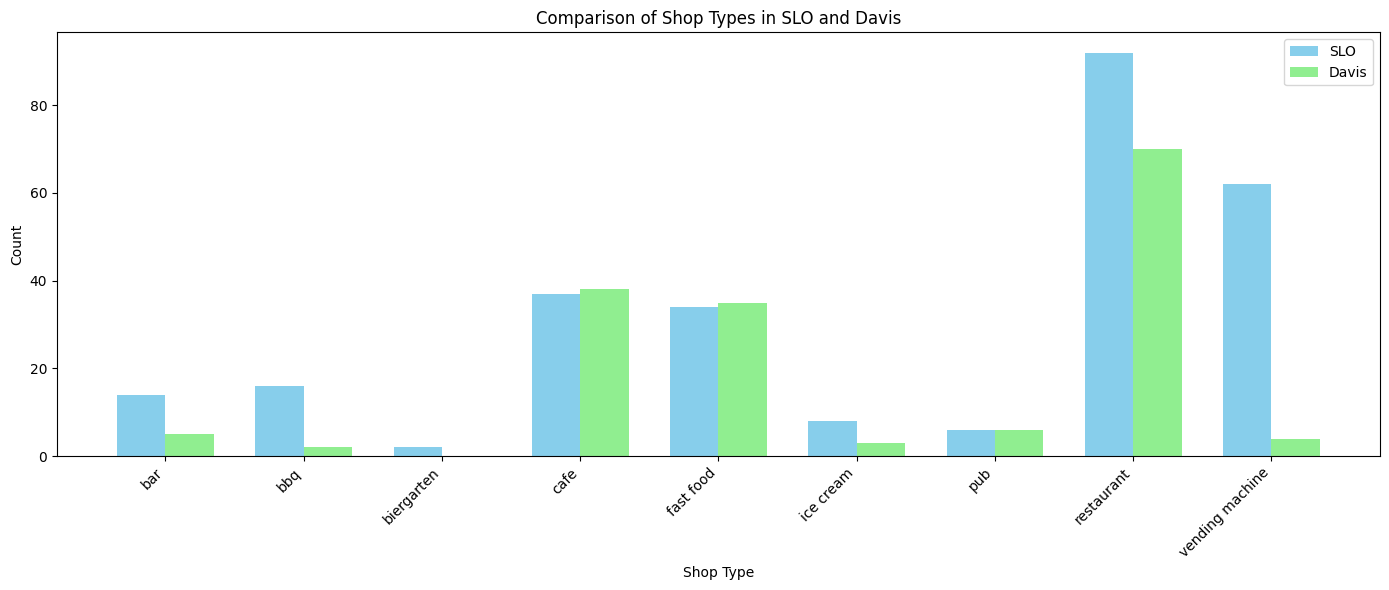

In [244]:
sloshop_counts = slofood_parquet['shop'].value_counts().dropna()  # drop NaN values
davisshop_counts = davisfood_parquet['shop'].value_counts().dropna()  # drop NaN values

all_shop_types = sorted(set(sloshop_counts.index).union(set(davisshop_counts.index)))

sloshop_counts = sloshop_counts.reindex(all_shop_types, fill_value=0)
davisshop_counts = davisshop_counts.reindex(all_shop_types, fill_value=0)

x = np.arange(len(all_shop_types))  # x positions for the shop types
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(14, 6))

bars1 = ax.bar(x - width/2, sloshop_counts.values, width, label='SLO', color='skyblue')
bars2 = ax.bar(x + width/2, davisshop_counts.values, width, label='Davis', color='lightgreen')

ax.set_title('Comparison of Shop Types in SLO and Davis')
ax.set_xlabel('Shop Type')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(all_shop_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

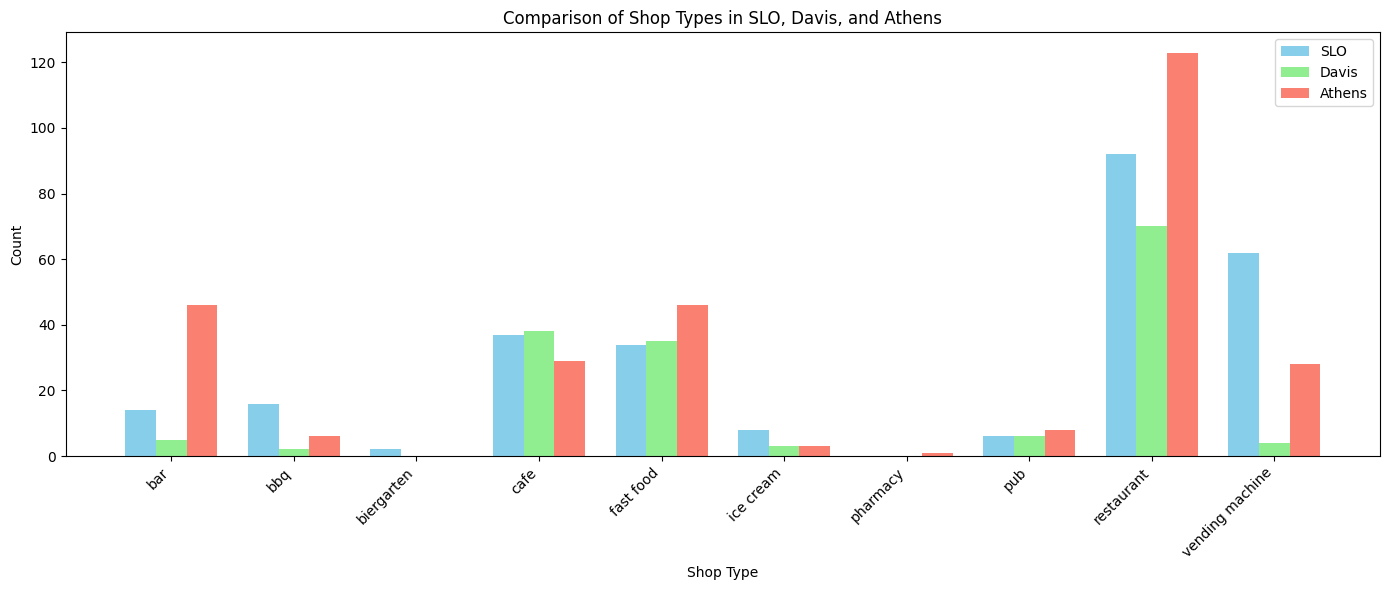

In [245]:
sloshop_counts = slofood_parquet['shop'].value_counts().dropna()  # drop NaN values
davisshop_counts = davisfood_parquet['shop'].value_counts().dropna()  # drop NaN values
athensshop_counts = athensfood_parquet['shop'].value_counts().dropna()  # drop NaN values

all_shop_types = sorted(set(sloshop_counts.index).union(set(davisshop_counts.index)).union(set(athensshop_counts.index))) # common shop types

sloshop_counts = sloshop_counts.reindex(all_shop_types, fill_value=0)
davisshop_counts = davisshop_counts.reindex(all_shop_types, fill_value=0)
athensshop_counts = athensshop_counts.reindex(all_shop_types, fill_value=0)

x = np.arange(len(all_shop_types))  # x positions for the shop types
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(14, 6))

bars1 = ax.bar(x - width, sloshop_counts.values, width, label='SLO', color='skyblue')
bars2 = ax.bar(x, davisshop_counts.values, width, label='Davis', color='lightgreen')
bars3 = ax.bar(x + width, athensshop_counts.values, width, label='Athens', color='salmon')

ax.set_title('Comparison of Shop Types in SLO, Davis, and Athens')
ax.set_xlabel('Shop Type')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(all_shop_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

This was added after I decided adding Athens would be better. From this graph,

- Davis doesn't have that many food-related shops
- Lots of convenience stores in Athens

## Name

According to the openstreetmap wiki page, `name` is the primary name of the feature in the real world. Sort of like an ID, but not, it is a clear way to identify the feature, with me already knowing restaurant/store names.

(https://wiki.openstreetmap.org/wiki/Key:name)

This variable isn't that useful on analysis since I assume that the top frequented names will be the big brand stores in `brand` (shown below). However, I can look at the unique names for finding local food spots, and this is useful for identifying places.

In [246]:
slofood_nameunique = slofood_parquet['name'].dropna().unique() # unique slo

print(f"Number of unique food places: {len(slofood_nameunique)}")
slofood_nameunique

Number of unique food places: 196


array(["Jersey Mike's Subs", 'Starbucks', 'Taco Bell', "Farb's Bakery",
       'Slo Asian Market', 'SLO Provisions', 'Black Sheep Bar & Grill',
       "Woodstock's Pizza", 'Yanagi Sushi', 'Bon Temps Creole Cafe',
       'My Thai', "Gus's Grocery", 'Village Market', '7-Eleven',
       'House of Bagels', 'Jaffa Cafe', 'Health Snacks',
       'Mustang Station', 'Blackhorse Espresso and Bakery', "Domino's",
       "Charlie's Place", "SLO Beverage 'n More", 'Subway',
       'Laurel Lane Liquors', "Pappy McGregor's", 'Chronic Tacos',
       "Nucci's", "Sally Loo's Wholesome Cafe",
       'Crossroads Liquor & Deli', "Sandy's Deli & Liquor", 'Raku Ramen',
       "Capriottti's Sandwich Shop", 'Panda Express', 'SLO Donut Company',
       'Five Guys', "Nucci's Pizza", 'Redbox', 'El Pollo Loco',
       "Pancho's Mexican Food", 'Eureka! Burger', "Louisa's Place",
       "Linnaea's Cafe", "Eddie's Grill", 'Thai Boat', "Kona's Deli",
       'Kumi-Ko Japanese', 'The Habit Burger Grill', 'Nautical Bean

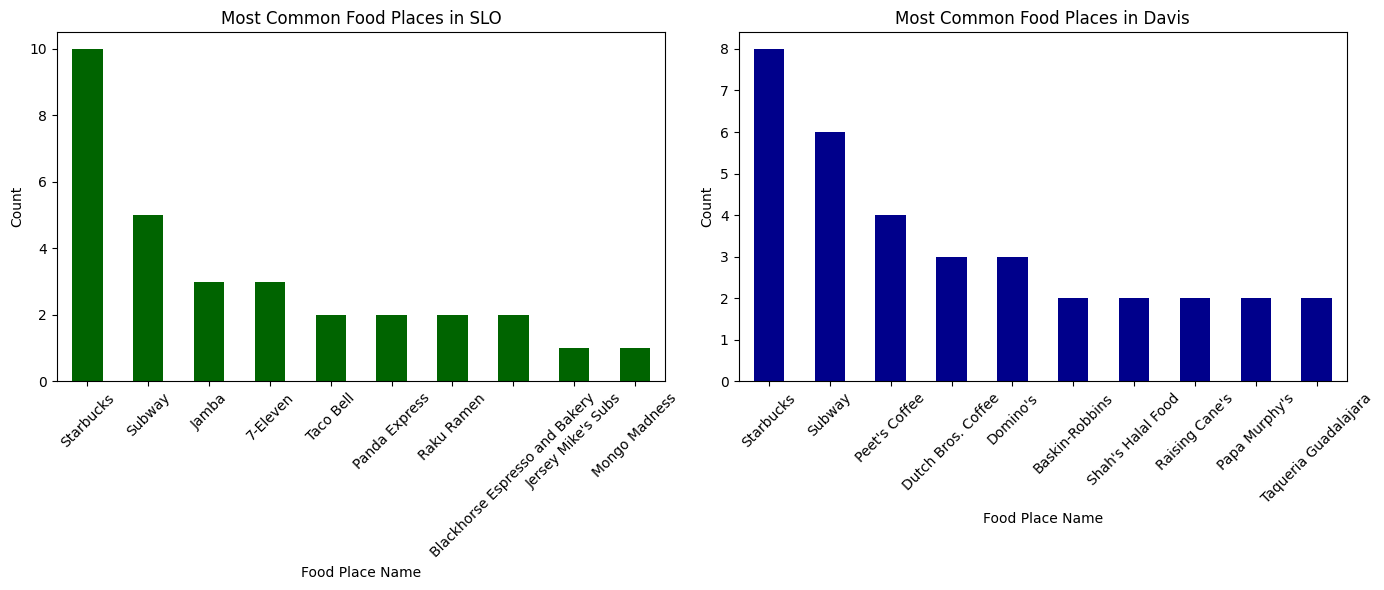

In [247]:
slo_name_counts = slofood_parquet['name'].value_counts().dropna()
davis_name_counts = davisfood_parquet['name'].value_counts().dropna()

top_slo_names = slo_name_counts.head(10)
top_davis_names = davis_name_counts.head(10)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the SLO food places
top_slo_names.plot(kind='bar', color='darkgreen', ax=ax[0])
ax[0].set_title('Most Common Food Places in SLO')
ax[0].set_xlabel('Food Place Name')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=45)

# Plot the Davis food places
top_davis_names.plot(kind='bar', color='darkblue', ax=ax[1])
ax[1].set_title('Most Common Food Places in Davis')
ax[1].set_xlabel('Food Place Name')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [248]:
name_with_null_brand = slofood_parquet[slofood_parquet['brand'].isnull()]['name']

print("Food places in SLO where 'brand' is null:")
for food_place in name_with_null_brand:
    print(food_place)

len(name_with_null_brand)

Food places in SLO where 'brand' is null:
Farb's Bakery
Slo Asian Market
SLO Provisions
Black Sheep Bar & Grill
Woodstock's Pizza
Yanagi Sushi
Bon Temps Creole Cafe
My Thai
Gus's Grocery
Village Market
House of Bagels
Jaffa Cafe
None
Health Snacks
Mustang Station
Blackhorse Espresso and Bakery
Charlie's Place
SLO Beverage 'n More
Laurel Lane Liquors
Pappy McGregor's
Chronic Tacos
Nucci's
None
Sally Loo's Wholesome Cafe
Crossroads Liquor & Deli
Sandy's Deli & Liquor
Raku Ramen
None
Capriottti's Sandwich Shop
SLO Donut Company
Nucci's Pizza
None
Pancho's Mexican Food
Eureka! Burger
Louisa's Place
Linnaea's Cafe
Eddie's Grill
Thai Boat
Kona's Deli
Kumi-Ko Japanese
Nautical Bean
La Locanda
Rocket Fizz
Central Coast Wines
New Earth Superfoods
Jan's Place
CJ’s BBQ
Thai Palace
Aisuru Sushi
Bowl'd
Bull's Tavern
Pluto's
Bings Bao Buns
UBATUBA, Acai bowls
Shadow Canyon Cellars
Giuseppe's Cucina Rustica
Doc Bernstein's Ice Cream Lab
McConnell's Fine Ice Creams
None
None
Urbane Cafe
Pancho Villa's

259

In [249]:
name_with_null_brand = davisfood_parquet[davisfood_parquet['brand'].isnull()]['name']

print("Food places in Davis where 'brand' is null:")
for food_place in name_with_null_brand:
    print(food_place)

len(name_with_null_brand)

Food places in Davis where 'brand' is null:
None
None
Cargo Coffee
Sodexho Coffee
Bio Brew
Gunrock Pub
Steve's Pizza
Cultivé Frozen Yogurt
Crepeville
Burgers and Brew
Yolo Berry
Silver Dragon
Make Fish
Bistro 33
Woodstock's Pizza
Kathmandu Kitchen
Village Bakery
Davis Noodle City
Davis Creamery
Sophia's Thai Kitchen
Village Pizza & Grill
Redrum Burger
Taqueria Guadalajara
Dos Coyotes
Lamppost Pizza
Shanghai Town
Chuy's Taqueria
Symposium Restaurant & Pizza House
Taste of Thai
The Hotdogger
The Dumpling House
Snack Shack
Sudwerk Brewing Co. The Dock
Mikuni's
None
None
Shah's Halal Food
CoHo South Café
Cuarto Dining Commons
Segundo Dining Commons
Tercero Dining Commons
None
KetMoRee
Konditorei
Let Them Eat Cake
Ding How
I Love Sushi
Taqueria Guadalajara
Sage Street Cafe
Sage Street Restaurant
Sage Street Market
Wok of Flame
Fluffy Donuts
The Old Teahouse
The Graduate
Coffee House
Natural Food Works and Farmer's Kitchen Cafe
El Toro Bravo
3rd and U Cafe
Ali Baba Cafe
Pho King 4 Restaurant

123

In [250]:
name_with_null_brand = athensfood_parquet[athensfood_parquet['brand'].isnull()]['name']

print("Food places in Athens where 'brand' is null:")
for food_place in name_with_null_brand:
    print(food_place)


len(name_with_null_brand)

Food places in Athens where 'brand' is null:
The National
None
Jittery Joe's Coffee
Baddies
Birdies
Big City Bread Cafe
Pulaski Heights BBQ
Trappeze Pub
Manhattan Cafe
Little Kings Shuffle Club
The Roadhouse
The Globe
Bar South
Woodford
Cutters Pub
Pauley's Crepe Bar
Rye Bar
General Beauregard's
City Bar
Walker's Coffee and Pub
Blue Sky Bar
Magnolia's
Bourbon Street
Buddha Bar
1785 Bar & Grill
Flanagan's & The Half Moon Pub
Allgood Lounge
On The Rocks
Boar's Head Lounge
South Kitchen + Bar
The Pine Bar & The Root Basement
Sakura Hibachi & Sushi Bar
Hodgson's Pharmacy & Gift Shop
Mediterranean Grill
Independent Baking Company
Jittery Joe's Coffee
Dawg Gone Good BBQ
Square One Fish Co.
Em's Kitchen
La Cabana de Don Juan
Athens Wok
Athens Bagel Company
The Grill
Ten Pins Tavern
The World Famous
Sabor Latino
Hi-Lo Lounge
The Old Pal
JR Crickets
Mannaweenta
Lighthouse Seafood
Vanish Night Club
Blind Pig Tavern
Taqueria La Parrilla
Choo Choo
Mama Sid's Pizza
Ideal Bagel Co.
None
Jittery Joe'

283

^^ These last three code chunks attempt to find local spots by extracting names of spots where they do not have a big brand. This is consistent with the total number of unique food spots in each town. So nothing surprising.

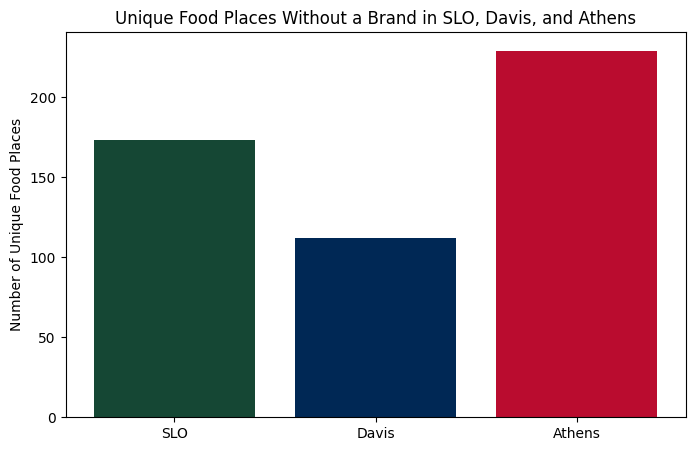

In [251]:
slo_no_brand = slofood_parquet[slofood_parquet['brand'].isnull()]['name'].nunique()
davis_no_brand = davisfood_parquet[davisfood_parquet['brand'].isnull()]['name'].nunique()
athens_no_brand = athensfood_parquet[athensfood_parquet['brand'].isnull()]['name'].nunique()

# school colors
colors = ['#154734', '#002855', '#BA0C2F']  # SLO (green), Davis (blue), Athens (red)

# plot
plt.figure(figsize=(8, 5))
plt.bar(['SLO', 'Davis', 'Athens'], [slo_no_brand, davis_no_brand, athens_no_brand], color=colors)

plt.ylabel("Number of Unique Food Places")
plt.title("Unique Food Places Without a Brand in SLO, Davis, and Athens")

plt.show()